## STAT 628 Module 2

# Body Fat Prediction
Authors (Thurs_Group3): Zheng Ni, Jingpeng Weizhou, Zifeng Wang, Ke Chen

## 1. Introduction

Body fat percentage is a measure of obesity (total mass of fat divided by total body mass), which is crucial index to describe people's health condition. 

In fact, many reserachers have proposed  various accurate way to calculate body fat percentage, while these methods always require costly measurement. In hence, we would like to construct a simple but also precise "rule of thumb" method to predict body fat percentage of males using available clinical measurements.

In this project, we try with multiple linear regression models with different subset of features and finally choose the best model with highest accuracy and robustness.


## 2. Data Description

The dataset contains 252 men with measurements of their percentage of body fat and various body circumference measurements. Overall, the response variable is **BODYFAT** and there are 16 explained variables including **AGE,WEIGHT,HEIGHT**, etc. The following table shows the structure of our dataset.

In [2]:
setwd('/Users/kechen/WISC/628/Module 2')
data = read.csv('BodyFat.csv',header = TRUE)
data[1:5,]

IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
1,12.6,1.0708,23,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
2,6.9,1.0853,22,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
3,24.6,1.0414,22,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
4,10.9,1.0751,26,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
5,27.8,1.0340,24,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Based on previous research, we know that **DENSITY** is almost perfectly correlated with **BODYFAT**, which can also be captured by the formula, *BODYFAT=448/DENSITY-406* (shown as below). Consequently, we cannot view **DENSITY** as a reliable variable.

In [4]:
data['density.inverse'] = 1 / data['DENSITY']
summary(lm(BODYFAT~density.inverse,data))


Call:
lm(formula = BODYFAT ~ density.inverse, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0510 -0.1612 -0.0480  0.0700 15.3135 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -405.786      3.994  -101.6   <2e-16 ***
density.inverse  448.183      4.214   106.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.142 on 250 degrees of freedom
Multiple R-squared:  0.9784,	Adjusted R-squared:  0.9783 
F-statistic: 1.131e+04 on 1 and 250 DF,  p-value: < 2.2e-16


The following table are the explained variables we would use in the our model.

|**AGE**|**WEIGHT**|**HEIGHT**|**ADIPOSITY**|**NECK**|**CHEST**|**ABDOMEN**|**HIP**|**THIHG**|**KNEE**|**ANKLE**|**BICEPS**|**FOREARM**|**WRIST**|
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|years|lbs|inches|bmi|cm|cm|cm|cm|cm|cm|cm|cm|cm|cm|

## 3. Data Preprocessing

Before we go into modeling part, we have to check whether there are missing values and outliers in our model. Based on the code below, we find there is no missing values in our dataset, so we don't need to use imputation method. As for the outliers, we would check the boxplot first to see if there are some data beyond 75% quantile.

From the boxplots below, we find some people have extremely low height, some have extremely high weight and bodyfat and even one man has 0 bodyfat which are beyond the possible range. So we think these records are outliers.

Number of missing values: 0 
Outliers: 42 39 216 182

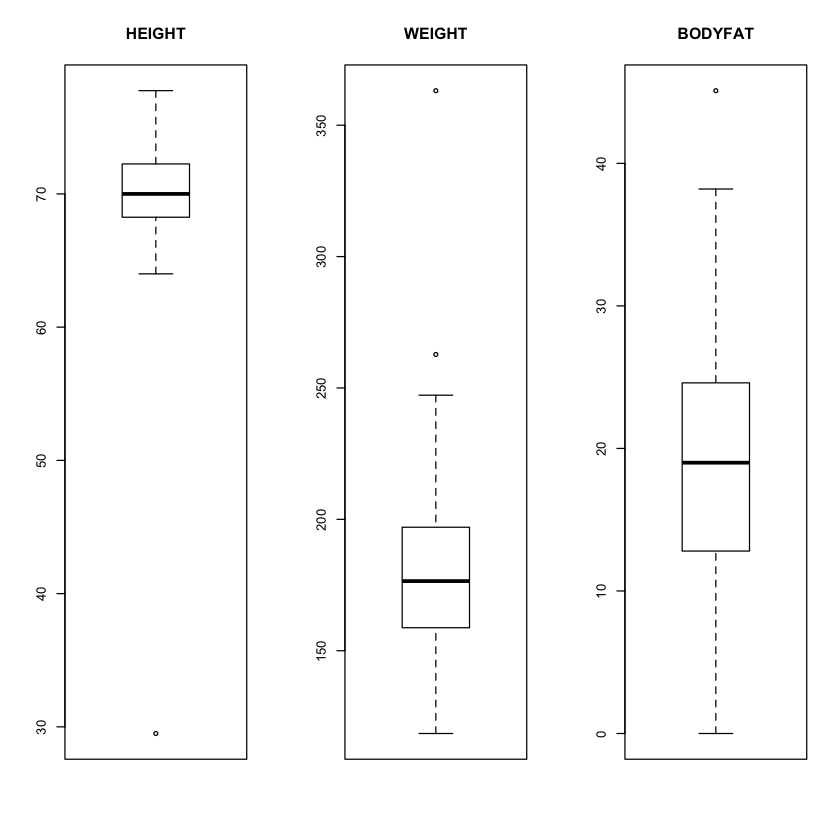

In [15]:
cat('Number of missing values:',sum(is.na(data)),'\n')
par(mfrow=c(1,3))
boxplot(data$HEIGHT,main='HEIGHT')
boxplot(data$WEIGHT,main='WEIGHT') 
boxplot(data$BODYFAT,main='BODYFAT')
cat('Outliers:',c(which(data$HEIGHT<40),which(data$WEIGHT>300),which(data$BODYFAT>40),which(data$BODYFAT==0)))

On the other hand, we can also utilize the relationship between **BODYFAT** and **DENSITY** and cook's distance to detect the outliers. The result from the following graph also suggests that records with index 182, 216 are outliers.

Warning message in install.packages("MASS"):
“installation of package ‘MASS’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


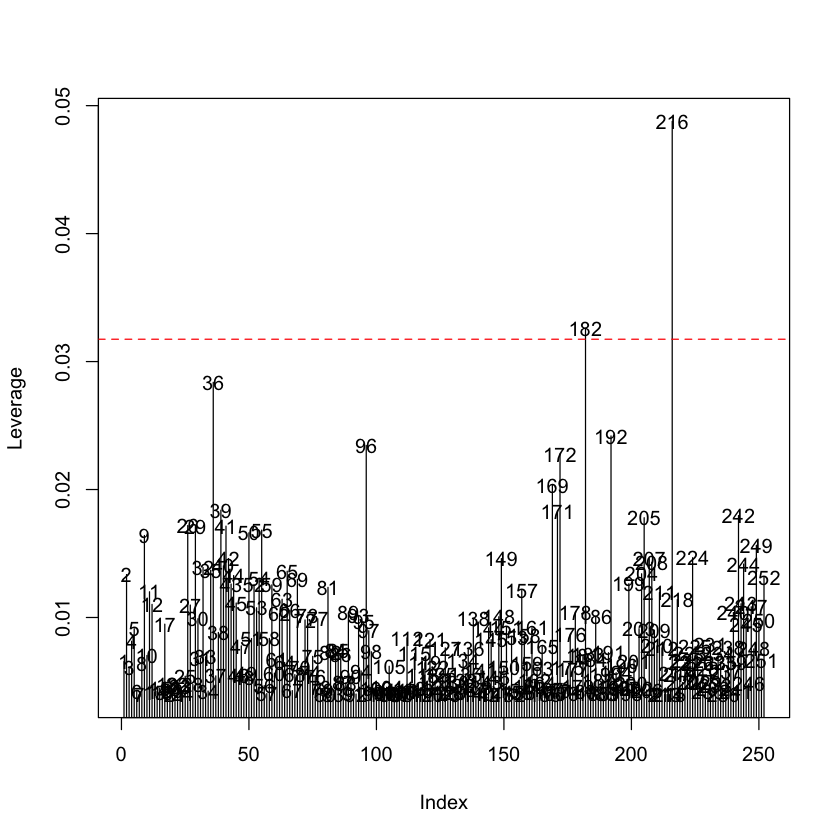

In [19]:
lm.density = lm(BODYFAT~density.inverse,data)
install.packages("MASS");library(MASS)
lm.density.hats = hatvalues(lm.density)
plot(lm.density.hats, type = "h", ylab = "Leverage") 
index = 1:length(data[,1])
text(lm.density.hats, labels = index, cex = 1) 
abline(h=2*4/252,lty=2,col='red')

Based on the boxplots and Cook's Distance, we think the records 39,42,182,216 are outliers and we would delete them in order to get more robust models.